# Linear Regression

## 1 - Description

Linear regression on $p$ variables focusses on fitting a straight line in $p$-dimensions that passes as close as possible to the data points in order to reduce error.

- A supervised learning technique
- Useful for predicting a quantitative response
- Linear Regression attempts to fit a function to predict a response variable
    - The problem is reduced to a paramteric problem of finding a set of parameters
    - The function is limited to having a straight line form

## 2- Advertising Dataset

The Advertising dataset is obtained from http://www-bcf.usc.edu/~gareth/ISL/data.html and contains 200 datapoints of sales of a particular product, and TV, newspaper and radio advertising budgets (all figures are in units of $1,000s).

In [1]:
# Import modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
from numpy.random import RandomState
import math
%matplotlib inline

In [2]:
# Import Advertising dataset (http://www-bcf.usc.edu/~gareth/ISL/data.html)
advert = pd.read_csv("Advertising.csv").iloc[:,1:]

In [3]:
print("Number of observations (n) =",advert.shape[0])
print("Number of predictor variables (p) =",advert.shape[1]-1)
print()
print("Advertising.csv")
advert.head()

Number of observations (n) = 200
Number of predictor variables (p) = 3

Advertising.csv


,TV,radio,newspaper,sales
0,230.1,37.8,69.2,22.1
1,44.5,39.3,45.1,10.4
2,17.2,45.9,69.3,9.3
3,151.5,41.3,58.5,18.5
4,180.8,10.8,58.4,12.9


The response variable is "sales". The predictor variables are "TV", "radio" and "newspaper".

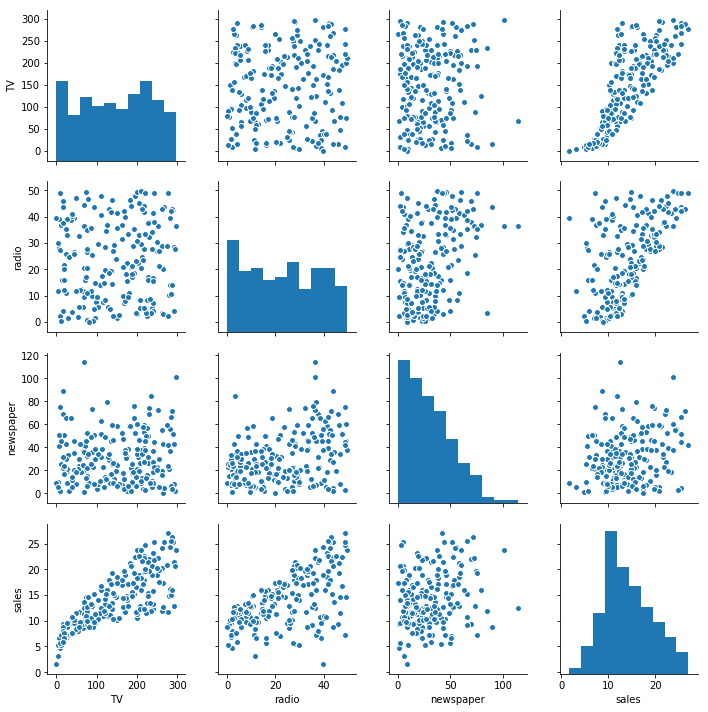

In [4]:
sns.pairplot(data=advert)

By looking at a pairplot to see the simple relationships between the variables, we see a strong positive correlation between sales and TV. A similar relationship between sales and radio is also observed. Newspaper and radio seem to have a slight positive correlation also. We can see this in the correlation matrix below.

In [5]:
advert.corr()

,TV,radio,newspaper,sales
TV,1.000000,0.054809,0.056648,0.782224
radio,0.054809,1.000000,0.354104,0.576223
newspaper,0.056648,0.354104,1.000000,0.228299
sales,0.782224,0.576223,0.228299,1.000000


## 3- Linear Regression

The idea behind Linear Regression is that we reduce the problem of estimating the response variable, $Y$ = sales, by assuming there is a linear function of the predictor variables, $X_1$ = TV, $X_2$ = radio and $X_3$ = newspaper which describes $Y$. This reduces the problem to that of solving for the parameters $\beta_0$, $\beta_1$, $\beta_2$ and $\beta_3$ in the equation:

$$Y \approx \beta_0 + \beta_1 X_1 + \beta_2 X_2 + \beta_3 X_3 + \epsilon$$

where $\epsilon$ is the error term. After approximating the coefficients $\beta_i$ as $\hat{\beta}_i$, we obtain an approximation, $\hat{Y}$ of $Y$. The coefficients $\hat{\beta}_i$ are obtained using the observed realisations of the random variables $X_i$. Namely, $X_i = (x_{1i},x_{2i},x_{3i},...,x_{ni})$ are n observations of $X_i$ where $i = 1,2,...,p$. 

We first limit the problem to $p=1$. For example, we are looking to estimate the coefficients in the equation

$$Y \approx \beta_0 + \beta_1 X_1 + \epsilon$$

using the $n$ data points $(x_{11},y_{11}),(x_{21},y_{21}),...,(x_{n1},y_{n1})$. We can define the prediction discrepency of a particular prediction as the difference between the observed value and the predicted value. This is representated in mathematical notation for observation $i$ as $y_i - \hat{y}_i$. Letting $\hat{Y} = \hat{\beta}_0 + \hat{\beta}_1 X_1$ we have $y_i - \hat{y}_i = \epsilon_i$. i.e. the error in the prediction of point observation $i$.

In summary, we are looking for a straight line to fit to the following data points as well as possible:

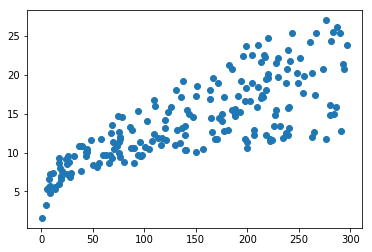

In [6]:
plt.scatter(data=advert, x='TV', y='sales')

#plt.plot([advert['TV'].min(),advert['TV'].max()], [advert['sales'].min(),advert['sales'].max()], 'k-')

In order to calculate appropriate values for parameters $\beta_i$, we would need a method of defining what it means for a line to be a good fit. A popular method is "Ordinary Least Squares". This method relies on minimising the Residual Sum of Squared errors (RSS). i.e. we are looking to minimise $RSS = \sum_{i=1}^n \epsilon_i^2$.

For the 1-parameter case we have that (the semi-colon below means the value of the parameters given the data we have observed) 

$$RSS(\hat{\beta}_0,\hat{\beta}_1;X) = \sum_{i=1}^n \epsilon_i^2 = \sum_{i=1}^n (y_i-\hat{\beta}_0 - \hat{\beta}_1 x_i)^2$$

We would like to find the parameters $(\beta_0,\beta_1)$ which minimise RSS. We first find the partial derivates:

$$\frac{\partial RSS}{\partial \hat{\beta_0}} = -2 [ \sum_{i=1}^n y_i - \sum_{i=1}^n \hat{\beta}_0 - \sum_{i=1}^n \hat{\beta}_1 x_i]$$

$$\frac{\partial RSS}{\partial \hat{\beta_1}} = -2 [ \sum_{i=1}^n y_i x_i - \sum_{i=1}^n \hat{\beta}_0 x_i - \sum_{i=1}^n \hat{\beta}_1 x_i^2]$$

Then

$$\frac{\partial RSS}{\partial \hat{\beta_0}} = 0 \implies  \hat{\beta}_0 = \frac{\sum_{i=1}^n y_i - \hat{\beta}_1 \sum_{i=1}^n y_i}{n} = \frac{n \bar{y} - \hat{\beta}_1 n \bar{x}}{n} = \bar{y} - \hat{\beta}_1 \bar{x}$$

$$\frac{\partial RSS}{\partial \hat{\beta_1}} = 0 \implies  \sum_{i=1}^n y_i x_i - \hat{\beta}_0 \sum_{i=1}^n x_i - \hat{\beta}_1 \sum_{i=1}^n x_i^2 = 0 \implies \hat{\beta}_1 = \frac{n \bar{y} \bar{x} - \sum_{i=1}^n y_i x_i}{n \bar{x}^2 - \sum_{i=1}^n x_i^2} = \frac{\sum_{i=1}^n y_i x_i - n \bar{y} \bar{x}}{\sum_{i=1}^n x_i^2 - n \bar{x}^2} = \frac{\sum_{i=1}^n y_i x_i - n \bar{y} \bar{x} - n \bar{y} \bar{x} + n\bar{y} \bar{x}}{\sum_{i=1}^n x_i^2 - n \bar{x}^2 -n\bar{x}^2 + n\bar{x}^2} = \frac{\sum_{i=1}^n x_i y_i - \sum_{i=1}^n y_i \bar{x} - \sum_{i=1}^n x_i \bar{y}  + \sum_{i=1}^n \bar{y} \bar{x}}{\sum_{i=1}^n x_i^2 - \sum_{i=1}^n x_i \bar{x} - \sum_{i=1}^n x_i \bar{x} + \sum_{i=1}^n \bar{x}^2}$$

Where, in the penultimate line we completed the square and in the last equality we used the equality $n\bar{y} \bar{x} = \sum_{i=1}^n y_i \bar{x} = \sum_{i=1}^n x_i \bar{y}$ and $n\bar{x}^2 = n\bar{x} \bar{x} = \sum_{i=1}^n x_i \bar{x}$. Factorising

$$\hat{\beta}_1 = \frac{\sum_{i=1}^n (x_i - \bar{x})(y_i - \bar{y})}{\sum_{i=1}^n (x_i - \bar{x})^2}$$

In the above, we have used the fact that $\hat{\mu} = \bar{x} = \frac{1}{n} \sum_{i=1}^n$ is an unbiased *Maximum Likelihood Estimator* (MLE) for the population mean $\mu$ (see Appendix).

We have now found the values of $(\hat{\beta}_0,\hat{\beta}_1)$ which corresponds to the extrema of RSS. We will still need to show that this is indeed a minima.

From Calculus, we know that if $\frac{\partial^2 RSS}{\partial \hat{\beta}_0 ^2} \frac{\partial^2 RSS}{\partial \hat{\beta}_1 ^2} - (\frac{\partial^2 RSS}{\partial \hat{\beta}_0 \partial \hat{\beta}_1})^2 > 0$, this is an extrema and not an inflexion point. Additionally, if $\frac{\partial^2 RSS}{\partial \hat{\beta}_0 ^2} > 0$ and $\frac{\partial^2 RSS}{\partial \hat{\beta}_1 ^2} > 0$ this is a minima.

We have that

$$\frac{\partial^2 RSS}{\partial \hat{\beta}_0 ^2} = 2n > 0$$
$$\frac{\partial^2 RSS}{\partial \hat{\beta}_1 ^2} = 2 \sum_{i=1}^n x_i^2 > 0$$
$$\frac{\partial^2 RSS}{\partial \hat{\beta}_0 \partial \hat{\beta}_1} = 2 \sum_{i=1}^n x_i$$

So,

$\frac{\partial^2 RSS}{\partial \hat{\beta}_0 ^2} \frac{\partial^2 RSS}{\partial \hat{\beta}_1 ^2} - (\frac{\partial^2 RSS}{\partial \hat{\beta}_0 \partial \hat{\beta}_1})^2 = (2n) (2 \sum_{i=1}^n x_i^2) - (2 \sum_{i=1}^n x_i)^2 > 0 \; \forall \; n>1$ (see Appendix)

This means that this is indeed a minima (since we have satisfied the conditions stated above). 

The equation

$$\hat{Y} = \hat{\beta}_0 + \hat{\beta}_1 X_1$$

then defines a straight line of best fit which minimises the expected value of the errors (residuals). From the form of this line, we can see that $\hat{\beta}_0$ corresponds to the value of $\hat{Y}$ if the independent variable $X_1$ is zero. $\hat{\beta}_1$ is then the gradient. 

In the following we construct 3 functions dependent on a single independent variable and attach an error term and calculate the best fit. The three functions are chosen as:

1- $f_1(x) = 4.67 + 5.07*x$

2- $f_2(x) = 4.67 + 5.07*x^2$

3- $f_3(x) = 4.67 + 5.07*sin(x)$

In [155]:
#f_1(x)=4.67+5.07∗x
def f_1(x):
    return 4.67 + 5.07*x

#f_2(x)=4.67+5.07∗x2
def f_2(x):
    return 4.67 + 5.07*x**2

#f_3(x)=4.67+5.07∗sin(x/20)
def f_3(x):
    return 4.67 + 5.07*math.sin(x/20)

In [48]:
# Set the seed
r = np.random.RandomState(101)
X = 100*r.rand(1000)

#Error term with sigma = 10, mu = 0
E_1 = 10*r.randn(1000)

#Error term with sigma = 500, mu = 0
E_2 = 500*r.randn(1000)

#Error term with sigma = 19, mu = 0
E_3 = 1*r.randn(1000)

#Response variables
Y_1 = list(map(f_1,X))+E_1
Y_2 = list(map(f_2,X))+E_2
Y_3 = list(map(f_3,X))+E_3

First case 1- f_1

Text(0,0.5,'f_1(x)')

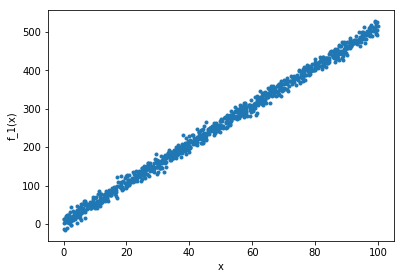

In [9]:
fig = plt.figure()
axes = fig.add_axes([0.1,0.1,0.8,0.8])
axes.plot(X,Y_1,'.')
axes.set_xlabel('x')
axes.set_ylabel('f_1(x)')

Fit the model $\hat{Y} = \hat{\beta}_0 + \hat{\beta}_1 X_1$ to the data. We know that 

$$\hat{\beta}_1 = \frac{\sum_{i=1}^n (x_i - \bar{x})(y_i - \bar{y})}{\sum_{i=1}^n (x_i - \bar{x})^2}$$

and

$$\hat{\beta}_0 = \bar{y} - \hat{\beta}_1 \bar{x}$$

In [10]:
#Find the mean of the data for f_1
x_bar1 = np.mean(X)
y_bar1 = np.mean(Y_1)

numerator = 0
denominator = 0

for i in range(len(Y_1)):
    numerator += (X[i] - x_bar1)*(Y_1[i] - y_bar1)
    denominator += (X[i] - x_bar1)**2
    
beta1_1 = numerator/denominator
beta1_0 = y_bar1 - beta1_1*x_bar1

print('Y = {beta_0} + {beta_1} * X'.format(beta_0 = beta1_0, beta_1 = beta1_1))

Y = 5.50124312485292 + 5.064254524922961 * X


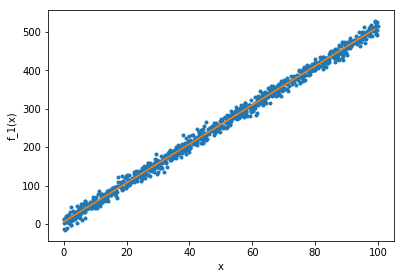

In [49]:
x1 = np.linspace(0,99,1000) # 1000 linearly spaced numbers
y1 = beta1_0 + beta1_1 * x1 # The equation using the betas above

fig = plt.figure()
axes = fig.add_axes([0.1,0.1,0.8,0.8])
axes.plot(X,Y_1,'.')
axes.set_xlabel('x')
axes.set_ylabel('f_1(x)')
axes.plot(x1,y1)

Let's see what the residuals look like by plotting them

This is roughly a normal distribution with mean -1.2157386208855315e-14 and standard deviation 10.08588495757817


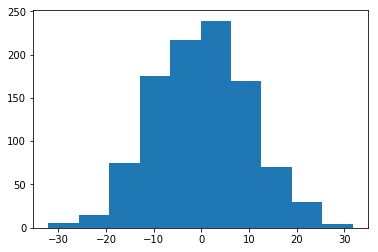

In [12]:
y1_fitted = beta1_0 + beta1_1 * X
Res_1 = y1_fitted - Y_1

plt.hist(Res_1)

print('This is roughly a normal distribution with mean {mean} and standard deviation {std}'\
      .format(mean=np.mean(Res_1),std=np.std(Res_1)))

Since the residuals are roughly normally distributed, our model may be a good choice. Now let's do the same for f_2.

Text(0,0.5,'f_2(x)')

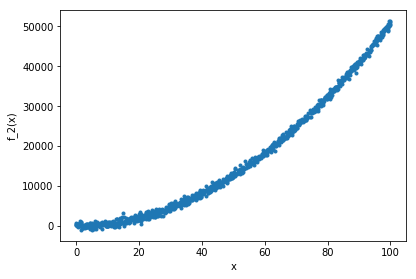

In [13]:
fig = plt.figure()
axes = fig.add_axes([0.1,0.1,0.8,0.8])
axes.plot(X,Y_2,'.')
axes.set_xlabel('x')
axes.set_ylabel('f_2(x)')

In [14]:
#Find the mean of the data for f_2
x_bar2 = np.mean(X)
y_bar2 = np.mean(Y_2)

numerator = 0
denominator = 0

for i in range(len(Y_2)):
    numerator += (X[i] - x_bar2)*(Y_2[i] - y_bar2)
    denominator += (X[i] - x_bar2)**2
    
beta2_1 = numerator/denominator
beta2_0 = y_bar2 - beta2_1*x_bar2

print('Y = {beta_0} + {beta_1} * X'.format(beta_0 = beta2_0, beta_1 = beta2_1))

Y = -8445.98030682202 + 506.16066894401735 * X


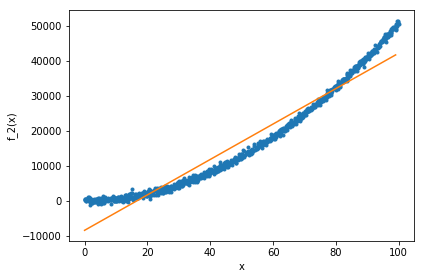

In [15]:
x2 = np.linspace(0,99,1000) # 1000 linearly spaced numbers
y2 = beta2_0 + beta2_1 * x2

fig = plt.figure()
axes = fig.add_axes([0.1,0.1,0.8,0.8])
axes.plot(X,Y_2,'.')
axes.set_xlabel('x')
axes.set_ylabel('f_2(x)')
axes.plot(x2,y2)

The residuals are certainly not from a normal distribution


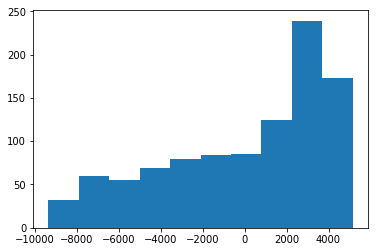

In [16]:
y2_fitted = beta2_0 + beta2_1 * X
Res_2 = y2_fitted - Y_2

plt.hist(Res_2)

print('The residuals are certainly not from a normal distribution')

So let's try $X^2$ as a parameter instead of $X$ in our linear model.

In [17]:
X_2 = X**2

#Find the mean of the data for f_3
x_bar22 = np.mean(X_2)
y_bar22 = np.mean(Y_2)

numerator = 0
denominator = 0

for i in range(len(Y_2)):
    numerator += (X_2[i] - x_bar22)*(Y_2[i] - y_bar22)
    denominator += (X_2[i] - x_bar22)**2
    
beta22_1 = numerator/denominator
beta22_0 = y_bar22 - beta22_1*x_bar22

print('Y = {beta_0} + {beta_1} * X^2'.format(beta_0 = beta22_0, beta_1 = beta22_1))

Y = 14.470063153316005 + 5.075020979320466 * X^2


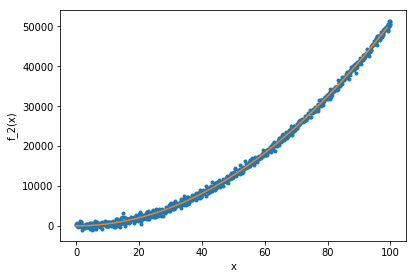

In [18]:
x22 = np.linspace(0,99,1000) # 1000 linearly spaced numbers
y22 = beta22_0 + beta22_1 * ((x22)**2)

fig = plt.figure()
axes = fig.add_axes([0.1,0.1,0.8,0.8])
axes.plot(X,Y_2,'.')
axes.set_xlabel('x')
axes.set_ylabel('f_2(x)')
axes.plot(x22,y22)

This is roughly a normal distribution with mean -1.1250449460931123e-12 and standard deviation 518.5583078222347


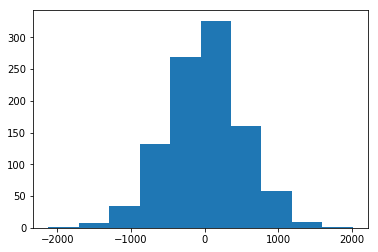

In [19]:
y22_fitted = beta22_0 + beta22_1 * X**2
Res_22 = y22_fitted - Y_2

plt.hist(Res_22)

print('This is roughly a normal distribution with mean {mean} and standard deviation {std}'\
      .format(mean=np.mean(Res_22),std=np.std(Res_22)))

This shows that we can transform an independent variable and apply linear regression in order to regress the response variable onto the transformed Explanatory variable. This increases the power of linear regression techniques.

Now let's apply linear regression to f_3.

Text(0,0.5,'f_3(x)')

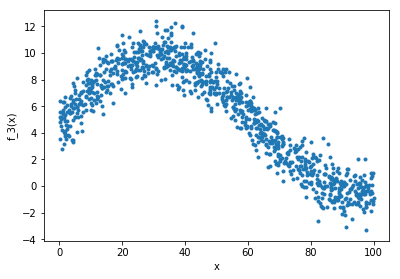

In [20]:
fig = plt.figure()
axes = fig.add_axes([0.1,0.1,0.8,0.8])
axes.plot(X,Y_3,'.')
axes.set_xlabel('x')
axes.set_ylabel('f_3(x)')

In [21]:
#Find the mean of the data for f_2
x_bar3 = np.mean(X)
y_bar3 = np.mean(Y_3)

numerator = 0
denominator = 0

for i in range(len(Y_3)):
    numerator += (X[i] - x_bar3)*(Y_3[i] - y_bar3)
    denominator += (X[i] - x_bar3)**2
    
beta3_1 = numerator/denominator
beta3_0 = y_bar3 - beta3_1*x_bar3

print('Y = {beta_0} + {beta_1} * X'.format(beta_0 = beta3_0, beta_1 = beta3_1))

Y = 10.511143457700811 + -0.1011987818100197 * X


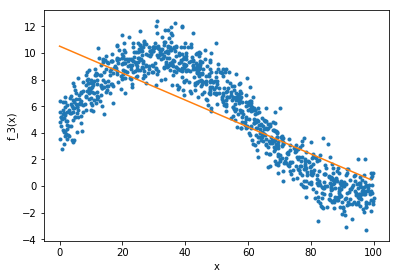

In [22]:
x3 = np.linspace(0,99,1000) # 1000 linearly spaced numbers
y3 = beta3_0 + beta3_1 * x3

fig = plt.figure()
axes = fig.add_axes([0.1,0.1,0.8,0.8])
axes.plot(X,Y_3,'.')
axes.set_xlabel('x')
axes.set_ylabel('f_3(x)')
axes.plot(x3,y3)

This not a normal distribution but it is not that far off.


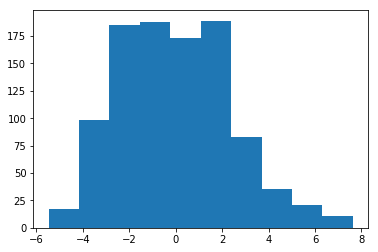

In [23]:
y3_fitted = beta3_0 + beta3_1 * X
Res_3 = y3_fitted - Y_3

plt.hist(Res_3)

print('This not a normal distribution but it is not that far off.')

Even though a plot of the residuals does not show a clear divergence from a normal distribution, it is clear from the predicted-observed plot that this is not a good model and does not fit the data in a satisfactory manner. We therefore need more tools in order to asses the level of fit.

A metric we can use in order to assess the accuracy of the fit is the R-Squared ($R^2$) statistic. The $R^2$ statistic measures the percentage of variability of the response variable that is explained by the explanatory variable. This is mathematically:

$$R^2 = \frac{TSS-RSS}{TSS}$$

where $TSS = \sum_{i=1}^n(y_i - \bar{y})^2$ is the *total sum of squares* and $RSS = \sum_{i=1}^n (y_i - \hat{y}_i)^2$ is the *residual sum of squares*.

In [24]:
TSS_3 = 0
RSS_3 = 0

for i in range(len(X)):
    TSS_3 += (Y_3[i] - y_bar3)**2
    RSS_3 += (Y_3[i] - y3_fitted[i])**2
    
R_sq_3 = (TSS_3 - RSS_3)/TSS_3
print('R^2 = {}'.format(R_sq_3))

R^2 = 0.5940625125965683


This means that roughly 59% of the variability in Y_3 is explained by X. Let's calculate the $R^2$ statistic for all the models above. 

In [25]:
def TSS_RSS(y_observed,y_fitted):
    TSS = 0
    RSS = 0
    
    y_bar = np.mean(y_observed)

    for i in range(len(X)):
        TSS += (y_observed[i] - y_bar)**2
        RSS += (y_observed[i] - y_fitted[i])**2
        
    return TSS,RSS

In [26]:
TSS_1, RSS_1 = TSS_RSS(Y_1,y1_fitted)
    
R_sq_1 = (TSS_1 - RSS_1)/TSS_1
print('Model for Y_1: Explanatory variable X for Y_1 - R^2 = {}'.format(R_sq_1))



TSS_2,RSS_2 = TSS_RSS(Y_2,y2_fitted)
    
R_sq_2 = (TSS_2 - RSS_2)/TSS_2
print('Model for Y_2: Explanatory variable X for Y_2 - R^2 = {}'.format(R_sq_2))



TSS_22,RSS_22 = TSS_RSS(Y_2,y22_fitted)
    
R_sq_22 = (TSS_22 - RSS_22)/TSS_22
print('Model for Y_2: Explanatory variable X^2 for Y_2 - R^2 = {}'.format(R_sq_22))



TSS_3,RSS_3 = TSS_RSS(Y_3,y3_fitted)

R_sq_3 = (TSS_3 - RSS_3)/TSS_3
print('Model for Y_3: Explanatory variable X for Y_3 - R^2 = {}'.format(R_sq_3))

Model for Y_1: Explanatory variable X for Y_1 - R^2 = 0.9951845734408926
Model for Y_2: Explanatory variable X for Y_2 - R^2 = 0.9336613222418227
Model for Y_2: Explanatory variable X^2 for Y_2 - R^2 = 0.99880452106502
Model for Y_3: Explanatory variable X for Y_3 - R^2 = 0.5940625125965683


From the above we can see that the model for $Y_1$ that is linear in $X$ is satisfactory; The model for $Y_2$ that is non-linear exaplains more variability of the response variable than the linear model; The model for $Y_3$ shows that we are probably not fitting the correct form of the function, i.e. we have introduced bias in that the real function is not of the form $a+bX$ for constants $a$ and $b$. We can try combinations of $X$, $X^2$, $X^3$ as well. We do this after we have introduced a much simpler way of obtaining the above fits using Scikit-Learn packages.

Below, we use sklearn.linear_model.LinearRegression() in order to fit and sklearn.metrics.r2_score() in order to calculate the $R^2$ statistic.

In [27]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

lm1 = LinearRegression()
lm1.fit(X.reshape(-1,1),Y_1.reshape(-1,1))
print('Model for Y_1: Explanatory variable X for Y_1')
print('beta_0 = {}'.format(lm1.intercept_[0]))
print('beta_1 = {}'.format(lm1.coef_[0][0]))
y1_fitted_sklearn = lm1.intercept_[0] + lm1.coef_[0][0]*X
print('R^2 = {}'.format(r2_score(Y_1,y1_fitted_sklearn)))

print()
print()

lm2 = LinearRegression()
lm2.fit(X.reshape(-1,1),Y_2.reshape(-1,1))
print('Model for Y_2: Explanatory variable X for Y_2')
print('beta_0 = {}'.format(lm2.intercept_[0]))
print('beta_1 = {}'.format(lm2.coef_[0][0]))
y2_fitted_sklearn = lm2.intercept_[0] + lm2.coef_[0][0]*X
print('R^2 = {}'.format(r2_score(Y_2,y2_fitted_sklearn)))

print()
print()

lm22 = LinearRegression()
lm22.fit((X**2).reshape(-1,1),Y_2.reshape(-1,1))
print('Model for Y_2: Explanatory variable X^2 for Y_2')
print('beta_0 = {}'.format(lm22.intercept_[0]))
print('beta_1 = {}'.format(lm22.coef_[0][0]))
y22_fitted_sklearn = lm22.intercept_[0] + lm22.coef_[0][0]*X**2
print('R^2 = {}'.format(r2_score(Y_2,y22_fitted_sklearn)))

print()
print()

lm3 = LinearRegression()
lm3.fit(X.reshape(-1,1),Y_3.reshape(-1,1))
print('Model for Y_3: Explanatory variable X for Y_3')
print('beta_0 = {}'.format(lm3.intercept_[0]))
print('beta_1 = {}'.format(lm3.coef_[0][0]))
y3_fitted_sklearn = lm3.intercept_[0] + lm3.coef_[0][0]*X
print('R^2 = {}'.format(r2_score(Y_3,y3_fitted_sklearn)))

print()
print()

# Now we try adding the variables X,X^2 and X^3

#Create transformed variables
X2 = X**2
X3 = X**3

lm32 = LinearRegression()
X3_collection = pd.concat([pd.DataFrame(X,columns=['X']),pd.DataFrame(X**2,columns=['X2']),pd.DataFrame(X**3,columns=['X3'])],axis=1)
lm32.fit(X3_collection,Y_3.reshape(-1,1))
print('Model for Y_3: Explanatory variables X,X^2,X^3 for Y_3')
print('beta_0 = {}'.format(lm32.intercept_[0]))
print('beta_1 = {}'.format(lm32.coef_[0][0]))
print('beta_2 = {}'.format(lm32.coef_[0][1]))
print('beta_3 = {}'.format(lm32.coef_[0][2]))
y32_fitted_sklearn = lm32.intercept_[0] + lm32.coef_[0][0]*X + lm32.coef_[0][1]*X**2 + lm32.coef_[0][2]*X**3
print('R^2 = {}'.format(r2_score(Y_3,y32_fitted_sklearn)))

Model for Y_1: Explanatory variable X for Y_1
beta_0 = 5.501243124853005
beta_1 = 5.064254524922959
R^2 = 0.9951845734408926


Model for Y_2: Explanatory variable X for Y_2
beta_0 = -8445.980306821977
beta_1 = 506.16066894401644
R^2 = 0.9336613222418227


Model for Y_2: Explanatory variable X^2 for Y_2
beta_0 = 14.470063153316005
beta_1 = 5.075020979320466
R^2 = 0.99880452106502


Model for Y_3: Explanatory variable X for Y_3
beta_0 = 10.511143457700808
beta_1 = -0.10119878181001966
R^2 = 0.5940625125965684


Model for Y_3: Explanatory variables X,X^2,X^3 for Y_3
beta_0 = 3.664431201636692
beta_1 = 0.48709842203796394
beta_2 = -0.011179330358454434
beta_3 = 5.867605764948042e-05
R^2 = 0.9229011520420615


In the above, we fit using 3 explanatory variables, namely $X$, $X^2$, $X^3$ with coefficients $\beta_1$, $\beta_2$, $\beta_3$ respectively. We can see that we have a much improved $R^2$ statistic meaning we have managed to explain much more of the data using the transformed variables we have created. We can plot the model to see how well it follows the response variable.

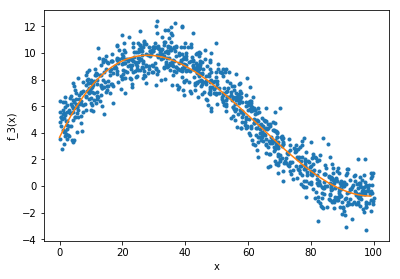

In [28]:
x32 = np.linspace(0,99,1000) # 1000 linearly spaced numbers
y32 = lm32.intercept_[0] + lm32.coef_[0][0]*x32 + lm32.coef_[0][1]*x32**2 + lm32.coef_[0][2]*x32**3

fig = plt.figure()
axes = fig.add_axes([0.1,0.1,0.8,0.8])
axes.plot(X,Y_3,'.')
axes.set_xlabel('x')
axes.set_ylabel('f_3(x)')
axes.plot(x32,y32)

We can also check the residual plot

This is roughly a normal distribution with mean -1.7408297026122454e-15 and standard deviation 1.043797076853439


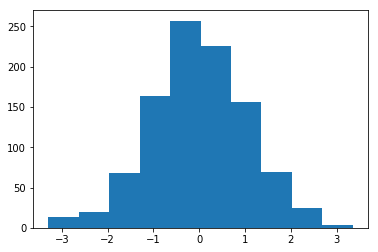

In [29]:
y32_fitted_sklearn = lm32.intercept_[0] + lm32.coef_[0][0]*X + lm32.coef_[0][1]*X**2 + lm32.coef_[0][2]*X**3
Res_32 = y32_fitted_sklearn - Y_3

plt.hist(Res_32)

print('This is roughly a normal distribution with mean {mean} and standard deviation {std}'\
      .format(mean=np.mean(Res_32),std=np.std(Res_32)))

It is not a surprise that we were able to fit a function of the form $f(x) = \beta_0 + \beta_1 x + \beta_2 x^2 + \beta_3 x^3$. Using taylor expansion, $f(x) = sin(x)$ estimated around the point $x=0$ as

$$f(x=0) = f(0) + f^{(1)}(0)x + f^{(2)}(0)x^2/(2!) + f^{(3)}(0)x^3/(3!) + O(x^4)$$
$$= \sin(0) + \cos(0)x - \sin(0)x^2/(2!) -\cos(0)x^3/(3!)$$
$$= x - x^3/(6)$$

If we apply Taylor series expansion to $f(x) = 4.67 + 5.07 sin(x/20)$ instead:

$$f(x=0) = 4.67 + \frac{5.07}{20}\cos(0)x-\frac{5.07}{20^3}\cos(0)x^3/(3!)=4.67 + 0.25x - 1 \times 10^{-4} x^3$$

Let's plot this along with the above for smaller values of X for which this approximation of sin(x) is acceptable.

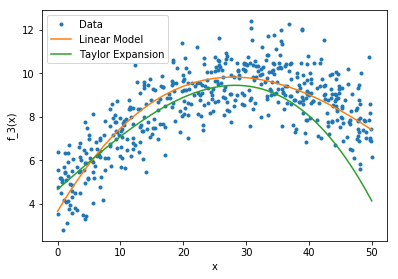

In [30]:
x32 = np.linspace(0,50,1000) # 1000 linearly spaced numbers
y32 = lm32.intercept_[0] + lm32.coef_[0][0]*x32 + lm32.coef_[0][1]*x32**2 + lm32.coef_[0][2]*x32**3
y_taylor_32 = 4.67 + (5.07/20)*x32 + 0*x32**2 - (5.07/(20**3 * 6))*x32**3
X_small = list(filter(lambda x: x < 50,X))
Y_small = Y_3[pd.concat([pd.DataFrame(X,columns=['X']),pd.DataFrame(Y_3,columns=['Y'])],axis=1).apply(lambda x: x[0]<50,axis=1)]

fig = plt.figure()
axes = fig.add_axes([0.1,0.1,0.8,0.8])
axes.plot(X_small,Y_small,'.',label='Data')
axes.set_xlabel('x')
axes.set_ylabel('f_3(x)')
axes.plot(x32,y32,label='Linear Model')
axes.plot(x32,y_taylor_32,label='Taylor Expansion')
axes.legend()

In addition to the $R^2$ statistic, it is useful to assess whether a variable is statistically significant. To do this for a variable $X$ with coefficient $\beta_1$, we test the null hypothesis

$$H_O: \beta_1 = 0$$

against

$$H_A: \beta_1 \neq 0$$

For the first model we have the fitted model

In [31]:
print('f(x) = {} + {} X'.format(lm1.intercept_[0],lm1.coef_[0][0]))

f(x) = 5.501243124853005 + 5.064254524922959 X


The standard errors of the estimators $\hat{\beta}_0$ and $\hat{\beta}_1$ for the coefficients have the form

$$SE(\beta_0) = \sqrt{\sigma^2 [\frac{1}{n} + \frac{\bar{x}^2}{\sum_{i=1}^n (x_i - \bar{x})^2}]} \approx  RSE\sqrt{ [\frac{1}{n} + \frac{\bar{x}^2}{\sum_{i=1}^n (x_i - \bar{x})^2}]}$$

Where RSE is the *residual standard error* estimating the population $\sigma = \sqrt{Var(\epsilon)}$ and has the form $RSE = \sqrt{\frac{\sum_{i=1}^n \epsilon_i^2}{n-2}} = \sqrt{\frac{RSS}{n-2}}$.

$$SE(\beta_1) = \sqrt{   \frac{ \sigma^2 }{ \sum_{i=1}^n (x_i - \bar{x})^2 }   } \approx RSE\sqrt{   \frac{ 1 }{ \sum_{i=1}^n (x_i - \bar{x})^2 }   }$$

(PROOF of these equations?)

Using the standard errors, we can then conduct the hypothesis test above as a t-test. We have that 

$$\frac{ \hat{\beta_0} - \beta_0^{(0)} }{ SE(\beta_0) } \sim t_{n-2}$$

$$\frac{ \hat{\beta_1} - \beta_1^{(0)} }{ SE(\beta_1) } \sim t_{n-2}$$

where $^{(0)}$ denotes the null value.

(PROOF that this is distributed as student t?)

In [32]:
# we need the scipy.stats package for the t-distribution
from scipy import stats

# number of observations n
n = len(X)

# residual standard error
RSE_1 = np.sqrt(RSS_1/(n-2))

# variance of x = sum (x_i - x_bar)^2. Note that this is the population variance calculation
# so we would need to multiply by n
varx_1 = np.var(X)

# mean of x
meanx_1 = np.mean(X)

SE_beta_0 = RSE_1 * np.sqrt(1.0/n + meanx_1**2/(n*varx_1))
SE_beta_1 = RSE_1 * np.sqrt(1.0/(n*varx_1))

print('SE(beta_0) = {}, SE(beta_1) = {}'.format(SE_beta_0,SE_beta_1))

# null hypothesis
betanull_0 = 0
betanull_1 = 0

tstatistic1_0 = (beta1_0 - betanull_0)/SE_beta_0
tstatistic1_1 = (beta1_1 - betanull_1)/SE_beta_1

print('beta_0 t-statistic = {}'.format(tstatistic1_0))
print('beta_1 t-statistic = {}'.format(tstatistic1_1))

# p-value
# the following function calculates the area under the student t pdf with 2 degrees of freedom that is less than -4.303
stats.t.cdf(-4.303,2)

# calculate the p-value using the tstatistic and degrees of freedom n-2
pval1_0 = stats.t.cdf(-tstatistic1_0,n-2)
pval1_1 = stats.t.cdf(-tstatistic1_1,n-2)

print('p-value for beta_0 = {}'.format(pval1_0))
print('p-value for beta_1 = {}'.format(pval1_1))
print('These are both statistically significant!')


SE(beta_0) = 0.6406034056188337, SE(beta_1) = 0.011151051418375258
beta_0 t-statistic = 8.587595814509644
beta_1 t-statistic = 454.150405635995
p-value for beta_0 = 1.685985282508196e-17
p-value for beta_1 = 0.0
These are both statistically significant!


In [151]:
def calcpvalue(X,y_observed,y_fitted,beta_0,beta_1,betanull_0,betanull_1):
    '''
    A function to calculate whether the coefficients in a model with 1 variable is statistically significant.
    X = a list for the data for the variable
    y_observed = the observed values for the response variable
    y_fitted = the predicted values of the model
    beta_0 = the intercept of the model
    beta_1 = the coefficient of the explanatory variable in the model
    betanull_0 = null hypothesis value for the intercept (usually 0)
    betanull_1 = null hypothesis value for the coefficient of the response variable (usually 0)
    '''
    # number of observations n
    n = len(X)

    # calculate RSS
    temp,RSS = TSS_RSS(y_observed,y_fitted)
    
    # residual standard error
    RSE = np.sqrt(RSS/(n-2))

    # variance of x = sum (x_i - x_bar)^2. Note that this is the population variance calculation
    # so we would need to multiply by n
    varx = np.var(X)

    # mean of x
    meanx = np.mean(X)

    SE_beta_0 = RSE * np.sqrt(1.0/n + meanx**2/(n*varx))
    SE_beta_1 = RSE * np.sqrt(1.0/(n*varx))

    print('SE(beta_0) = {}, SE(beta_1) = {}'.format(SE_beta_0,SE_beta_1))

    # null hypothesis
    betanull_0 = 0
    betanull_1 = 0

    tstatistic1_0 = (beta_0 - betanull_0)/SE_beta_0
    tstatistic1_1 = (beta_1 - betanull_1)/SE_beta_1

    print('beta_0 t-statistic = {}'.format(tstatistic1_0))
    print('beta_1 t-statistic = {}'.format(tstatistic1_1))

    # p-value

    # calculate the p-value using the tstatistic and degrees of freedom n-2
    # Multiply by 2 since it's a 2 tailed test
    if(tstatistic1_0 > 0):
        pval_0 = stats.t.cdf(-tstatistic1_0,n-2)*2
    else:
        pval_0 = stats.t.cdf(tstatistic1_0,n-2)*2
        
    if(tstatistic1_1 > 0):
        pval_1 = stats.t.cdf(-tstatistic1_1,n-2)*2
    else:
        pval_1 = stats.t.cdf(tstatistic1_1,n-2)*2

    print('p-value for beta_0 = {}'.format(pval_0))
    print('p-value for beta_1 = {}'.format(pval_1))
    if((pval_0 <= 0.05) and (pval_1 <=0.05)):
        print('These are both statistically significant!')
    elif(pval_0 <= 0.05):
        print('Only beta_0 is statistically significant!')
    elif(pval_1 <= 0.05):
        print('Only beta_1 is statistically significant!')
    else:
        print('The parameters of this model are not statistically significant!')

We can do the same calculations for significance for all the models using this function

In [152]:
print('Model for Y_1: Explanatory variable X for Y_1')
calcpvalue(X,Y_1,y1_fitted,beta1_0,beta1_1,0,0)

print()
print()

print('Model for Y_2: Explanatory variable X for Y_2')
calcpvalue(X,Y_2,y2_fitted,beta2_0,beta2_1,0,0)

print()
print()

print('Model for Y_2: Explanatory variable X^2 for Y_2')
calcpvalue(X**2,Y_2,y22_fitted,beta22_0,beta22_1,0,0)

print()
print()

print('Model for Y_3: Explanatory variable X for Y_3')
calcpvalue(X,Y_3,y3_fitted,beta3_0,beta3_1,0,0)

Model for Y_1: Explanatory variable X for Y_1
SE(beta_0) = 0.6406034056188337, SE(beta_1) = 0.011151051418375258
beta_0 t-statistic = 8.587595814509644
beta_1 t-statistic = 454.150405635995
p-value for beta_0 = 3.371970565016392e-17
p-value for beta_1 = 0.0
These are both statistically significant!


Model for Y_2: Explanatory variable X for Y_2
SE(beta_0) = 245.34955295438897, SE(beta_1) = 4.2708256878947495
beta_0 t-statistic = -34.424274285888536
beta_1 t-statistic = 118.51588098729522
p-value for beta_0 = 8.125468707425302e-172
p-value for beta_1 = 0.0
These are both statistically significant!


Model for Y_2: Explanatory variable X^2 for Y_2
SE(beta_0) = 24.614546607361707, SE(beta_1) = 0.005557804748590844
beta_0 t-statistic = 0.5878663289694033
beta_1 t-statistic = 913.1340896074505
p-value for beta_0 = 0.5567550098751695
p-value for beta_1 = 0.0
Only beta_1 is statistically significant!


Model for Y_3: Explanatory variable X for Y_3
SE(beta_0) = 0.15212372264589394, SE(beta_1)

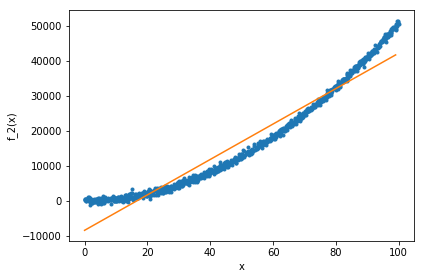

In [153]:
fig = plt.figure()
axes = fig.add_axes([0.1,0.1,0.8,0.8])
axes.plot(X,Y_2,'.')
axes.set_xlabel('x')
axes.set_ylabel('f_2(x)')
axes.plot(x2,y2)

We can use the statsmodels.api to verify our results

In [36]:
import statsmodels.api as sm
from scipy import stats

C:\Users\HVAD\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [110]:
print('Model for Y_1: Explanatory variable X for Y_1')

# add a column of ones to X
X_new = sm.add_constant(X)

# ordinary least squares approach to optimisation
est = sm.OLS(Y_1, X_new)

# fit the data to the model using OLS
est2 = est.fit()

# print a summary of the model
print(est2.summary())

print()
print()

#re-run the above for all the models

print('Model for Y_2: Explanatory variable X for Y_2')
X_new = sm.add_constant(X)
est = sm.OLS(Y_2, X_new)
est2 = est.fit()
print(est2.summary())

print()
print()

print('Model for Y_2: Explanatory variable X^2 for Y_2')
X_new = sm.add_constant(X**2)
est = sm.OLS(Y_2, X_new)
est2 = est.fit()
print(est2.summary())

print()
print()

print('Model for Y_3: Explanatory variable X for Y_3')
X_new = sm.add_constant(X)
est = sm.OLS(Y_3, X_new)
est2 = est.fit()
print(est2.summary())

print()
print()

print('Model for Y_3: Explanatory variables X,X^2,X^3 for Y_3')
# concatenate multiple variables
X_new = sm.add_constant(pd.concat([pd.DataFrame(X,columns=['X']),pd.DataFrame(X**2,columns=['X2']),pd.DataFrame(X**3,columns=['X3'])],axis=1))
est = sm.OLS(Y_3, X_new)
est2 = est.fit()
print(est2.summary())

Model for Y_1: Explanatory variable X for Y_1
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.995
Model:                            OLS   Adj. R-squared:                  0.995
Method:                 Least Squares   F-statistic:                 2.063e+05
Date:                Wed, 17 Oct 2018   Prob (F-statistic):               0.00
Time:                        12:27:37   Log-Likelihood:                -3730.1
No. Observations:                1000   AIC:                             7464.
Df Residuals:                     998   BIC:                             7474.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const 

It looks like the intercept for *Model for Y_2: Explanatory variable X^2 for Y_2* is not statistically significant. The intercept can then be omitted from the model and fitted again.

In [38]:
print('Model for Y_2: Explanatory variable X^2 for Y_2')
est = sm.OLS(Y_2, X**2)
est2 = est.fit()
print(est2.summary())

Model for Y_2: Explanatory variable X^2 for Y_2
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.999
Model:                            OLS   Adj. R-squared:                  0.999
Method:                 Least Squares   F-statistic:                 1.878e+06
Date:                Wed, 17 Oct 2018   Prob (F-statistic):               0.00
Time:                        10:27:30   Log-Likelihood:                -7670.2
No. Observations:                1000   AIC:                         1.534e+04
Df Residuals:                     999   BIC:                         1.535e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1  

This is a good fit also

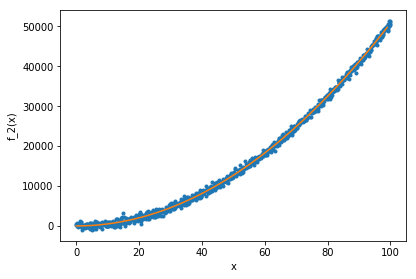

In [39]:
x23 = np.linspace(0,99,1000) # 1000 linearly spaced numbers
y23 = est2.params[0] * x23**2

fig = plt.figure()
axes = fig.add_axes([0.1,0.1,0.8,0.8])
axes.plot(X,Y_2,'.')
axes.set_xlabel('x')
axes.set_ylabel('f_2(x)')
axes.plot(x23,y23)

If we set $\beta_0=0$ in the derivation for $\hat{\beta_0}$ and $\hat{\beta_1}$ earlier in the article, we would have obtained the equation

$$\hat{\beta_1} = \frac{\sum_{i=1}^n y_i x_i}{\sum_{i=1}^n x_i^2}$$

Using this equation, we can reproduce the statsmodels solution above. Note that removing $\beta_0$ has changed $\beta_1$ slightly:

In [40]:
# remember that we are fitting the variable X^2
sum1 = np.sum(Y_2*X**2)
sum2 = np.sum(X**4)

beta23_1 = sum1/sum2

print('Y ~ {} X^2'.format(beta23_1))

Y ~ 5.077455649665152 X^2


#### F-Statistic

The F-Statistic answers the question 'Is there evidence that at least one of the explanatory variables is related to the response variable?'. This corresponds to a hypothesis test with:

$$H_O: \beta_0, \beta_1, ..., \beta_p = 0$$
$$H_A: \text{at least one of } \beta_i \text{ is non-zero}$$

The F-Statistic has the form:

$$F = \frac{(TSS - RSS)/p}{RSS/(n-p-1)}$$

where p is the number of explanatory variables/parameters. 

(DERIVATION of this equation?)

If $H_O$ is not true, the numerator in the above equation becomes larger, i.e. F > 1. If $H_0$ is true, then the F-Statistic is close to 1.

(PROOF of this - take expectation of numerator and denominator and these are both equal to Var($\epsilon$). If $H_A$ is true then the numerator > Var($\epsilon$))

We can use this to calculate the F-Statistics of the above models:

In [41]:
def FStat(n,p,TSS,RSS):
    F = ((TSS-RSS)/p)/(RSS/(n-p-1))
    print('The F-Statistic is {}'.format(F))

In [42]:
# we didn't calculate the last model ourselves, we used sklearn so we retrieve the coefficients
beta32_0 = lm32.intercept_[0]
beta32_1 = lm32.coef_[0][0]
beta32_2 = lm32.coef_[0][1]
beta32_3 = lm32.coef_[0][2]

In [43]:
print('Model for Y_1: Explanatory variable X for Y_1')
FStat(len(X),1,TSS_1,RSS_1)

print()
print()

#re-run the above for all the models

print('Model for Y_2: Explanatory variable X for Y_2')
FStat(len(X),1,TSS_2,RSS_2)

print()
print()

print('Model for Y_2: Explanatory variable X^2 for Y_2')
FStat(len(X),1,TSS_22,RSS_22)

print()
print()

print('Model for Y_3: Explanatory variable X for Y_3')
FStat(len(X),1,TSS_3,RSS_3)

print()
print()

TSS_32,RSS_32 = TSS_RSS(Y_3,y32_fitted_sklearn)

print('Model for Y_3: Explanatory variables X,X^2,X^3 for Y_3')
# now we have 3 explanatory variables
FStat(len(X),3,TSS_32,RSS_32)

Model for Y_1: Explanatory variable X for Y_1
The F-Statistic is 206252.59093933867


Model for Y_2: Explanatory variable X for Y_2
The F-Statistic is 14046.014046194661


Model for Y_2: Explanatory variable X^2 for Y_2
The F-Statistic is 833813.8656032282


Model for Y_3: Explanatory variable X for Y_3
The F-Statistic is 1460.506619784441


Model for Y_3: Explanatory variables X,X^2,X^3 for Y_3
The F-Statistic is 3974.1603226694533


These match the *statsmodels* outputs. We can also find the p-value of a coefficient/intercept using the F-Statistic. The F-Statistic formula becomes:

$$F = \frac{(RSS_0 - RSS)/q}{RSS/(n-p-1)}$$

where $RSS_0$ is the residual sum of squares for the model with $q$ removed parameters. The corresponding hypothesis test is then

$$H_0: \beta_i = 0 \text{ where i is one of the q removed parameters}$$
$$H_A: \text{at least one of those q parameters is non-zero}$$

Above, we ran a model for Y_2 which had an intercept, coefficient of X^2 and RSS of:

In [44]:
beta22_0, beta22_1, RSS_22

(14.470063153316005, 5.075020979320466, 268902718.6114595)

Here, we are going to calculate the p-value of the intercept for Y_2 when we try to fit an intercept as well as $X^2$. We do this by first fitting the full model including the intercept and getting the RSS value, then we fit the model without the intercept and get the RSS value. The Coefficient of X^2 and RSS for the model without the intercept was calculated to be

In [58]:
TSS_23,RSS_23 = TSS_RSS(Y_2,beta23_1 * X**2)
print('beta_1 = {}, RSS_0 = {}'.format(beta23_1,RSS_23))

beta_1 = 5.077455649665152, RSS_0 = 268995834.0780044


We now create a function to apply the formula shown above for calculating the F-Statistic for comparing models

In [75]:
def FStatCompare(n,p,q,RSS0,RSS):
    '''
    A function to calculate the F-Statistic when we are comparing models with different number of parameters.
    RSS0 is a sub-model of RSS
    '''
    F = ((RSS0-RSS)/q)/(RSS/(n-p-1))
    print('The F-Statistic is {}'.format(F))
    return F

Now we can confirm the p-value for the intercept

In [77]:
# This is the fitted values for the model with no intercept
Y23_fitted = beta23_1 * X**2

# These are the TSS and RSS for this model with no intercept
TSS_2_test,RSS_2_test = TSS_RSS(Y_2,Y23_fitted)

# RSS_22 is the RSS for the model with the intercept. RSS_23 is the RSS
# for the model without the intercept. We have p = 0 and q = 1 (i.e. we have 
# removed 1 parameter but there was only 1 parameter to begin with)
F = FStatCompare(len(X),0,1,RSS_23,RSS_22)

# the following function calculates the area underneath the cdf F-distribution with 
#dfn(degrees of freedom in the numerator)=1, 
#dfd(degrees of freedom in the denominator)=len(X)-2 less than 0.5
stats.f.cdf(0.5,1,len(X)-2)

print('The p-value of the intercept is {}'.format(1-stats.f.cdf(F,1,len(X)-2)))

The F-Statistic is 0.3459331001141355
The p-value of the intercept is 0.5565574505496756


Note that above, we removed the intercept and used the F-Statistic to calculate the p-value for the intercept. We can also remove the coefficient of X^2 and calculate the p-value of this coefficient using the same procedure as above. First fit the model as we have done before

In [69]:
lmOnlyIntercept = LinearRegression()
lmOnlyIntercept.fit((X*0).reshape(-1,1),Y_2.reshape(-1,1))
print('Model for Y_2: No explanatory variable for Y_2')
print('beta_0 = {}'.format(lmOnlyIntercept.intercept_[0]))
yOnlyIntercept_fitted_sklearn = lmOnlyIntercept.intercept_[0] + X*0
print('R^2 = {}'.format(r2_score(Y_2,yOnlyIntercept_fitted_sklearn)))

Model for Y_2: No explanatory variable for Y_2
beta_0 = 16763.308428792458
R^2 = 0.0


Next, calculate the RSS for this model we have just fitted

In [74]:
TSS_OnlyIntercept,RSS_OnlyIntercept = TSS_RSS(Y_2,yOnlyIntercept_fitted_sklearn)
print('beta_0 = {}, RSS_0 = {}'.format(lmOnlyIntercept.intercept_[0],RSS_OnlyIntercept))

beta_0 = 16763.308428792458, RSS_0 = 224933046282.3772


And now we calculate the p-value of the coefficient of X^2

In [154]:
# These are the TSS and RSS for this model with only intercept
TSS_2_test,RSS_2_test = TSS_RSS(Y_2,yOnlyIntercept_fitted_sklearn)

# RSS_22 is the RSS for the model with the intercept. RSS_23 is the RSS
# for the model without the intercept. We have p = 0 and q = 1 (i.e. we have 
# removed 1 parameter but there was only 1 parameter to begin with)
F = FStatCompare(len(X),0,1,RSS_2_test,RSS_22)

# the following function calculates the area underneath the cdf F-distribution with 
#dfn(degrees of freedom in the numerator)=1, 
#dfd(degrees of freedom in the denominator)=len(X)-2 less than 0.5
stats.f.cdf(0.5,1,len(X)-2)

print('The p-value of the X^2 coefficient is {}'.format(1-stats.f.cdf(F,1,len(X)-2)))

The F-Statistic is 834649.3504385022
The p-value of the X^2 coefficient is 1.1102230246251565e-16


### Synergy Effect

Suppose we havethe following function

$$f(x)=4.67+2*X_1+3*X_2+5.07∗X_1*X_2$$

We can see that there is a mixed term '$X_1 X_2$'. This is called a synergy effect.

Let's define this function and plot it

Text(0,0.5,'f(x)')

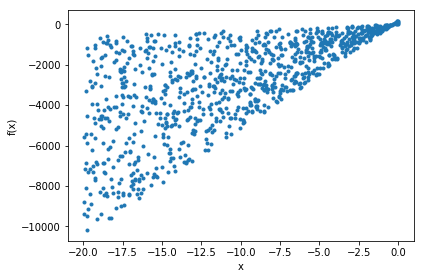

In [216]:
from mpl_toolkits.mplot3d import Axes3D

#f(x)=4.67+2*X_1+3*X_2+5.07∗X_1*X_2
def f(x1,x2):
    return 4.67+2*x1+30*x2+5.07*x1*x2
# Set the seed
r = np.random.RandomState(101)
X_1 = 100*r.rand(1000)
X_2 = -20*r.rand(1000)

#Error term with sigma = 10, mu = 0
E = 10*r.randn(1000)

#Response variables
Y = list(map(f,X_1,X_2))+E

fig = plt.figure()
axes = fig.add_axes([0.1,0.1,0.8,0.8])
axes.plot(X_2,Y,'.')
axes.set_xlabel('x')
axes.set_ylabel('f(x)')

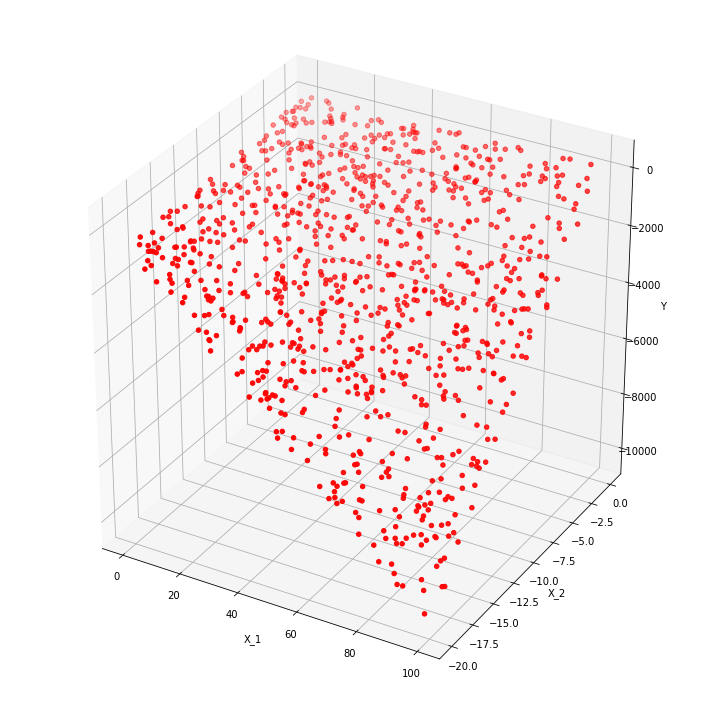

In [217]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(X_1, X_2, Y, c='r', marker='o')

ax.set_xlabel('X_1')
ax.set_ylabel('X_2')
ax.set_zlabel('Y')

plt.tight_layout()

In [221]:
print('Model for Y_2: Explanatory variable X^2 for Y_2')
X_new = sm.add_constant(pd.concat([pd.DataFrame(X_1,columns=['X_1']),pd.DataFrame(X_2,columns=['X_2']),pd.DataFrame(X_1*X_2,columns=['X_12'])],axis=1))
est = sm.OLS(Y, X_new)
est2 = est.fit()
print(est2.summary())

Model for Y_2: Explanatory variable X^2 for Y_2
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 1.644e+07
Date:                Wed, 17 Oct 2018   Prob (F-statistic):               0.00
Time:                        13:13:06   Log-Likelihood:                -3749.9
No. Observations:                1000   AIC:                             7508.
Df Residuals:                     996   BIC:                             7527.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
cons

## Appendix

### A1 - $(2n) (2 \sum_{i=1}^n x_i^2) - (2 \sum_{i=1}^n x_i)^2 > 0$

Statement: $(2n) (2 \sum_{i=1}^n x_i^2) - (2 \sum_{i=1}^n x_i)^2 > 0 \; \forall \; n > 1$

Proof: We prove this by induction on $n$. If n = 1, we have $(2n) (2 \sum_{i=1}^n x_i^2) - (2 \sum_{i=1}^n x_i)^2 = 0$, but this is not what we want.

Let n = 2 > 1. Then 

$$(2n) (2 \sum_{i=1}^n x_i^2) - (2 \sum_{i=1}^n x_i)^2 = 2 x_1^2 + 2 x_2^2 - (x_1 + x_2)^2 = 2 x_1^2 + 2 x_2^2 - x_1^2 - x_2^2 - 2x_1 x_2 = x_1^2 + x_2^2 - 2x_1 x_2 = (x_1 - x_2)^2  > 0$$

So we have proved the assertion for n = 2.

Let us prove the statement for n+1 assuming it is true for n.

i.e. Assume $n \sum_{i=1}^n x_i^2 - (\sum_{i=1}^n x_i)^2 > 0$

Then 

$$(n+1) \sum_{i=1}^{n+1} x_i^2 - (\sum_{i=1}^{n+1} x_i)^2 = (n+1)[\sum_{i=1}^{n} x_i^2 + x_{n+1}^2] - (\sum_{i=1}^{n} x_i + x_{n+1})^2 = [n \sum_{i=1}^n x_i^2 + \sum_{i=1}^n x_i^2 + (n+1)x_{n+1}^2] - (\sum_{i=1}^n x_i)^2 - x_{n+1}^2 + 2x_{n+1} \sum_{i=1}^n x_i$$

$$= n \sum_{i=1}^n x_i^2 - (\sum_{i=1}^n x_i)^2 + \sum_{i=1}^n x_i^2 + (n+1)x_{n+1}^2 - x_{n+1}^2 + 2x_{n+1} \sum_{i=1}^n x_i$$

by the assumption for n we have

$$> \sum_{i=1}^n x_i^2 + (n+1)x_{n+1}^2 - x_{n+1}^2 + 2x_{n+1} \sum_{i=1}^n x_i$$

by the assumption for n that $\sum_{i=1}^n x_i^2 > \frac{1}{n}(\sum_{i=1}^n x_i)^2$ we have

$$> \frac{1}{n}(\sum_{i=1}^n x_i)^2 + (n+1)x_{n+1}^2 - x_{n+1}^2 + 2x_{n+1} \sum_{i=1}^n x_i = \frac{1}{n}(\sum_{i=1}^n x_i)^2 + nx_{n+1}^2 + 2x_{n+1} \sum_{i=1}^n x_i = \frac{1}{n}[(\sum_{i=1}^n x_i)^2 + n^2 x_{n+1}^2 + 2n x_{n+1} \sum_{i=1}^n x_i]$$

$$=\frac{1}{n}[(\sum_{i=1}^n x_i)^2 + n^2 x_{n+1}^2 + 2n x_{n+1} \sum_{i=1}^n x_i]=\frac{1}{n}[(\sum_{i=1}^n x_i + n x_{n+1})^2] > 0$$